<a href="https://colab.research.google.com/github/AmulPatil/Case-Studies/blob/master/Version_1_pytorch_AV_emergency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorizati on.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from PIL import Image

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

In [ ]:
train_df = pd.read_csv("drive/My Drive/code/datasets/av_emergency/train/train.csv")
test_df = pd.read_csv("drive/My Drive/code/datasets/av_emergency/test.csv")
train_df.rename({'emergency_or_not':"target"},inplace=True,axis=1)
train_df.head()

,image_names,target
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [ ]:
#train_df['target'] = train_df['target'].astype('category').cat.codes
train_df.head(2),train_df.dtypes

(  image_names  target
 0    1503.jpg       0
 1    1420.jpg       0, image_names    object
 target          int64
 dtype: object)

In [ ]:
df_train = train_df.copy()
df_test = test_df.copy()

In [ ]:
def create_different_dir():

  train_imgs = os.listdir("drive/My Drive/code/datasets/av_emergency/train/images/")
  training_Images = train_df[(train_df['image_names']).isin(train_imgs)]['image_names']
  for img in (training_Images):
      im = Image.open("drive/My Drive/code/datasets/av_emergency/train/images/" + img)
      im.save("drive/My Drive/code/datasets/av_emergency/train/images/train/"+img)   

  testing_Images = test_df[(test_df['image_names']).isin(train_imgs)]['image_names']
  for img in (testing_Images):
      im = Image.open("drive/My Drive/code/datasets/av_emergency/train/images/" + img)
      im.save("drive/My Drive/code/datasets/av_emergency/train/images/test/"+img)   
  return

#create_different_dir() ,'run only once' 

Preparing data for Pytorch

In [ ]:
!pip install wtfml
!pip install pretrainedmodels

In [ ]:
import os
import torch
import albumentations

import numpy as np
import pandas as pd

import torch.nn as nn
from sklearn import metrics
from sklearn import model_selection
from torch.nn import functional as F

from wtfml.utils import EarlyStopping
from wtfml.engine import Engine
from wtfml.data_loaders.image import ClassificationLoader

import pretrainedmodels

In [ ]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


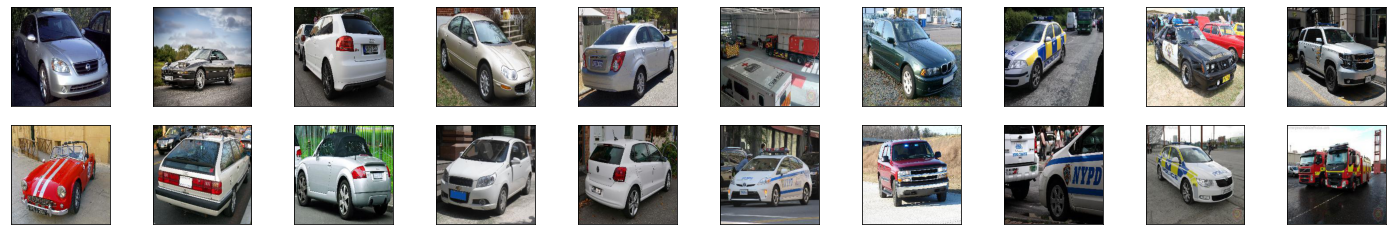

In [ ]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("drive/My Drive/code/datasets/av_emergency/train/images/test/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("drive/My Drive/code/datasets/av_emergency/train/images/test/" + img)
    plt.imshow(im)
    #lab = test_df.loc[test_df.image_names == img, 'emergency_or_not'].values
    #ax.set_title(f'Label: {lab}')

In [ ]:
np.array(im).shape

(224, 224, 3)

In [ ]:
print(pretrainedmodels.pretrained_settings['senet154'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [ ]:
#!wget "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth"  --no-check-certificate
#!mv "data.lip6.fr/cadene/pretrainedmodels" "drive/My Drive/code/datasets/av_emergency"

In [ ]:
class SEResnext50_32x4d(nn.Module):
    def __init__(self, pretrained='imagenet'):
        super(SEResnext50_32x4d, self).__init__()
        
        self.base_model = pretrainedmodels.__dict__[
            "se_resnext50_32x4d"
        ](pretrained=None)
        if pretrained is not None:
            self.base_model.load_state_dict(
                torch.load(
                    "drive/My Drive/code/datasets/av_emergency/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth"
                )
            )

        self.l0 = nn.Linear(2048, 1)
    
    def forward(self, image, targets):
        batch_size, _, _, _ = image.shape
        
        x = self.base_model.features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        
        out = self.l0(x)
        loss = nn.BCEWithLogitsLoss()(out, targets.view(-1, 1).type_as(x))

        return out, loss

In [ ]:
# create folds
df = pd.read_csv("drive/My Drive/code/datasets/av_emergency/train/train.csv")
df["kfold"] = -1    
df = df.sample(frac=1).reset_index(drop=True)
df.rename({'emergency_or_not':"target"},inplace=True,axis=1)
y = df.target.values
kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

df.to_csv("train_folds.csv", index=False)

In [ ]:
def train(fold):
    training_data_path = "drive/My Drive/code/datasets/av_emergency/train/images/train/"
    df = pd.read_csv("train_folds.csv")
    device = "cuda"
    epochs = 50#50
    train_bs = 32
    valid_bs = 16

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    model = SEResnext50_32x4d(pretrained="imagenet")
    model.to(device)

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_aug = albumentations.Compose(
        [
            albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
            albumentations.Flip(p=1),
            albumentations.Cutout(num_holes = 2,max_h_size=10,max_w_size=10)
        ]
    )

    valid_aug = albumentations.Compose(
        [
            albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)
        ]
    )

    train_images = df_train.image_names.values.tolist()
    train_images = [os.path.join(training_data_path, i ) for i in train_images]
    train_targets = df_train.target.values

    valid_images = df_valid.image_names.values.tolist()
    valid_images = [os.path.join(training_data_path, i ) for i in valid_images]
    valid_targets = df_valid.target.values

    train_dataset = ClassificationLoader(
        image_paths=train_images,
        targets=train_targets,
        resize=None,
        augmentations=train_aug,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_bs, shuffle=True, num_workers=4
    )

    valid_dataset = ClassificationLoader(
        image_paths=valid_images,
        targets=valid_targets,
        resize=None,
        augmentations=valid_aug,
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_bs, shuffle=False, num_workers=4
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=3,
        threshold=0.001,
        mode="max"
    )

    es = EarlyStopping(patience=5, mode="max")
    
    for epoch in range(epochs):
        train_loss = Engine.train(train_loader, model, optimizer, device=device)
        predictions, valid_loss = Engine.evaluate(
            valid_loader, model, device=device
        )
        predictions = np.vstack((predictions)).ravel()
        probs = torch.sigmoid(torch.tensor(predictions))
        threshold = 0.5
        predicted_vals = [1 if x  > threshold else 0 for x in probs]
        auc = metrics.roc_auc_score(valid_targets, predictions)
        accuracy = metrics.accuracy_score(valid_targets,predicted_vals)
        print(f"Epoch = {epoch}, AUC = {auc}, Accuracy = {accuracy}")
        scheduler.step(auc)

        es(auc, model, model_path=f"model_fold_{fold}.bin")
        if es.early_stop:
            print("Early stopping")
            break

In [ ]:
def predict(fold):
    test_data_path = "drive/My Drive/code/datasets/av_emergency/train/images/test/"
    df = pd.read_csv("drive/My Drive/code/datasets/av_emergency/test.csv")
    device = "cuda"
    model_path=f"model_fold_{fold}.bin"

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    aug = albumentations.Compose(
        [
            albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)
        ]
    )

    images = df.image_names.values.tolist()
    images = [os.path.join(test_data_path, i ) for i in images]
    target = np.zeros(len(images))

    test_dataset = ClassificationLoader(
        image_paths=images,
        targets=target,
        resize=None,
        augmentations=aug,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=16, shuffle=False, num_workers=4
    )

    model = SEResnext50_32x4d(pretrained=None)
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    predictions = Engine.predict(test_loader, model, device=device)
    predictions = np.vstack((predictions)).ravel()
    #print(predictions)
    return predictions

In [ ]:
train(0)

100%|██████████| 21/21 [00:06<00:00,  3.01it/s, loss=0.168]


Epoch = 0, AUC = 0.9836239174010061, Accuracy = 0.9333333333333333
Validation score improved (-inf --> 0.9836239174010061). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 1, AUC = 0.9842290382360728, Accuracy = 0.9424242424242424
Validation score improved (0.9836239174010061 --> 0.9842290382360728). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 2, AUC = 0.9834726371922393, Accuracy = 0.9454545454545454
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 3, AUC = 0.9836995575053894, Accuracy = 0.9515151515151515
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 4, AUC = 0.9819598351045724, Accuracy = 0.9515151515151515
EarlyStopping counter: 3 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 5, AUC = 0.9831322567225143, Accuracy = 0.9636363636363636
EarlyStopping counter: 4 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 6, AUC = 0.9844937786014145, Accuracy = 0.9545454545454546
Validation score improved (0.9842290382360728 --> 0.9844937786014145). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 7, AUC = 0.9838886577663478, Accuracy = 0.9575757575757575
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 8, AUC = 0.982829696304981, Accuracy = 0.9575757575757575
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 9, AUC = 0.9823002155742975, Accuracy = 0.9575757575757575
EarlyStopping counter: 3 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 10, AUC = 0.9821111153133393, Accuracy = 0.9606060606060606
EarlyStopping counter: 4 out of 5


100%|██████████| 21/21 [00:06<00:00,  3.01it/s, loss=0.178]

Epoch = 11, AUC = 0.982035475208956, Accuracy = 0.9606060606060606
EarlyStopping counter: 5 out of 5
Early stopping


In [ ]:
train(1)
train(2)
train(3)
train(4)

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 0, AUC = 0.9900182871075891, Accuracy = 0.9452887537993921
Validation score improved (-inf --> 0.9900182871075891). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 1, AUC = 0.9855227064919232, Accuracy = 0.9513677811550152
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 2, AUC = 0.9916946053032611, Accuracy = 0.9696048632218845
Validation score improved (0.9900182871075891 --> 0.9916946053032611). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 3, AUC = 0.9935995123437976, Accuracy = 0.9696048632218845
Validation score improved (0.9916946053032611 --> 0.9935995123437976). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 4, AUC = 0.9882276744894849, Accuracy = 0.9574468085106383
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 5, AUC = 0.984989332520573, Accuracy = 0.9513677811550152
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 6, AUC = 0.9848750380981409, Accuracy = 0.9483282674772037
EarlyStopping counter: 3 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 7, AUC = 0.9888372447424566, Accuracy = 0.9574468085106383
EarlyStopping counter: 4 out of 5


100%|██████████| 21/21 [00:07<00:00,  2.99it/s, loss=0.127]


Epoch = 8, AUC = 0.9896373056994818, Accuracy = 0.9544072948328267
EarlyStopping counter: 5 out of 5
Early stopping


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 0, AUC = 0.9875419079548918, Accuracy = 0.9361702127659575
Validation score improved (-inf --> 0.9875419079548918). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 1, AUC = 0.9878085949405669, Accuracy = 0.9331306990881459
Validation score improved (0.9875419079548918 --> 0.9878085949405669). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 2, AUC = 0.9868942395611094, Accuracy = 0.9452887537993921
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 3, AUC = 0.984570252971655, Accuracy = 0.9452887537993921
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 4, AUC = 0.988075281926242, Accuracy = 0.9544072948328267
Validation score improved (0.9878085949405669 --> 0.988075281926242). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 5, AUC = 0.9884181651935385, Accuracy = 0.9604863221884499
Validation score improved (0.988075281926242 --> 0.9884181651935385). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 6, AUC = 0.98849436147516, Accuracy = 0.9483282674772037
EarlyStopping counter: 1 out of 5


100%|██████████| 21/21 [00:07<00:00,  2.95it/s, loss=0.14]


Epoch = 7, AUC = 0.9893706187138068, Accuracy = 0.9574468085106383
Validation score improved (0.9884181651935385 --> 0.9893706187138068). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 8, AUC = 0.9886848521792136, Accuracy = 0.9574468085106383
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 9, AUC = 0.9888753428832673, Accuracy = 0.9604863221884499
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 10, AUC = 0.9892182261505638, Accuracy = 0.9513677811550152
EarlyStopping counter: 3 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 11, AUC = 0.9895230112770497, Accuracy = 0.9452887537993921
Validation score improved (0.9893706187138068 --> 0.9895230112770497). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 12, AUC = 0.9887991466016459, Accuracy = 0.9422492401215805
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 13, AUC = 0.9889515391648886, Accuracy = 0.9452887537993921
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 14, AUC = 0.9889515391648886, Accuracy = 0.9422492401215805
EarlyStopping counter: 3 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 15, AUC = 0.9892944224321853, Accuracy = 0.9544072948328267
EarlyStopping counter: 4 out of 5


100%|██████████| 21/21 [00:07<00:00,  2.92it/s, loss=0.15]


Epoch = 16, AUC = 0.9891039317281317, Accuracy = 0.9513677811550152
EarlyStopping counter: 5 out of 5
Early stopping


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 0, AUC = 0.987389515391649, Accuracy = 0.9513677811550152
Validation score improved (-inf --> 0.987389515391649). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 1, AUC = 0.9835797013105761, Accuracy = 0.9513677811550152
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 2, AUC = 0.9834273087473332, Accuracy = 0.9544072948328267
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 3, AUC = 0.9813319110027431, Accuracy = 0.9483282674772037
EarlyStopping counter: 3 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 4, AUC = 0.9793508076805852, Accuracy = 0.9331306990881459
EarlyStopping counter: 4 out of 5


100%|██████████| 21/21 [00:07<00:00,  2.95it/s, loss=0.175]


Epoch = 5, AUC = 0.9800746723559891, Accuracy = 0.9331306990881459
EarlyStopping counter: 5 out of 5
Early stopping


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 0, AUC = 0.9884562633343493, Accuracy = 0.9574468085106383
Validation score improved (-inf --> 0.9884562633343493). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 1, AUC = 0.9864370618713807, Accuracy = 0.9483282674772037
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 2, AUC = 0.9870085339835416, Accuracy = 0.9665653495440729
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 3, AUC = 0.9821319719597683, Accuracy = 0.9331306990881459
EarlyStopping counter: 3 out of 5


100%|██████████| 21/21 [00:07<00:00,  2.97it/s, loss=0.127]


Epoch = 4, AUC = 0.9903611703748857, Accuracy = 0.9544072948328267
Validation score improved (0.9884562633343493 --> 0.9903611703748857). Saving model!


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 5, AUC = 0.9853703139286802, Accuracy = 0.9361702127659575
EarlyStopping counter: 1 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 6, AUC = 0.9805318500457177, Accuracy = 0.9544072948328267
EarlyStopping counter: 2 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 7, AUC = 0.981065224017068, Accuracy = 0.9483282674772037
EarlyStopping counter: 3 out of 5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch = 8, AUC = 0.9804937519049071, Accuracy = 0.9148936170212766
EarlyStopping counter: 4 out of 5


100%|██████████| 21/21 [00:07<00:00,  2.94it/s, loss=0.198]

Epoch = 9, AUC = 0.980912831453825, Accuracy = 0.9240121580547113
EarlyStopping counter: 5 out of 5
Early stopping


In [ ]:
p1 = predict(0)
p2 = predict(1)
p3 = predict(2)
p4 = predict(3)
p5 = predict(4)

100%|██████████| 45/45 [00:14<00:00,  3.12it/s]


In [ ]:
predictions = (p1 + p2 + p3 + p4 + p5) / 5
probs = torch.sigmoid(torch.tensor(predictions))
threshold = 0.5
predicted_vals = [1 if x  > threshold else 0 for x in probs]
#probs


In [ ]:
np.array(predicted_vals)
#[ probs > threshold for item in probs if conditional ]
test_df.shape,len(predicted_vals)

((706, 1), 706)

In [ ]:

sample = pd.read_csv("drive/My Drive/code/datasets/av_emergency/test.csv")
sample.loc[:, "emergency_or_not"] = predicted_vals
sample.to_csv("submission_version_1.csv", index=False)

In [ ]:
sample.head(4)

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1


#public leaderboard Score(39) :0.9687500000

In [ ]:

sample_probs = pd.read_csv("drive/My Drive/code/datasets/av_emergency/test.csv")
sample_probs.loc[:, "emergency_or_not"] = probs
sample_probs.to_csv("submission_version_1_probs.csv", index=False)

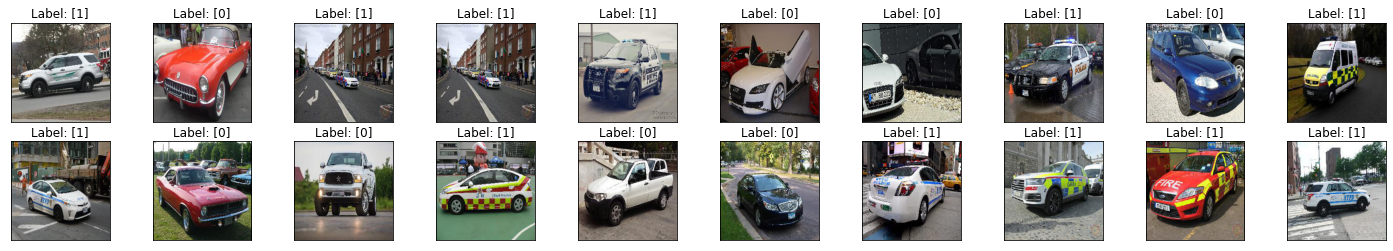

In [ ]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("drive/My Drive/code/datasets/av_emergency/train/images/test/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("drive/My Drive/code/datasets/av_emergency/train/images/test/" + img)
    plt.imshow(im)
    lab = sample.loc[sample.image_names == img, 'emergency_or_not'].values
    ax.set_title(f'Label: {lab}')